Starting data processing for ALL particles...
Processed 100000 particles... Time elapsed: 6.14s
Processed 200000 particles... Time elapsed: 12.28s
Processed 300000 particles... Time elapsed: 18.86s
Processed 400000 particles... Time elapsed: 25.04s
Processed 500000 particles... Time elapsed: 31.28s
Processed 600000 particles... Time elapsed: 37.06s
Processed 700000 particles... Time elapsed: 43.03s
Processed 800000 particles... Time elapsed: 48.69s
Processed 900000 particles... Time elapsed: 54.50s
Processed 1000000 particles... Time elapsed: 60.22s
Total particles processed: 1000000
Time taken for processing: 60.22 seconds
Total points for plotting: 1000000

--- Data Distribution Info (of ALL points) ---
X-axis (p/|z|) range: Min=0.001, Max=5.234
X-axis percentiles (1st, 5th, 95th, 99th): [0.142 0.321 2.448 3.034]
Y-axis (dE/dx) range: Min=0.019, Max=3220.000
Y-axis percentiles (1st, 5th, 95th, 99th): [ 1.26   1.331  3.454 11.567]
--------------------------------------------------



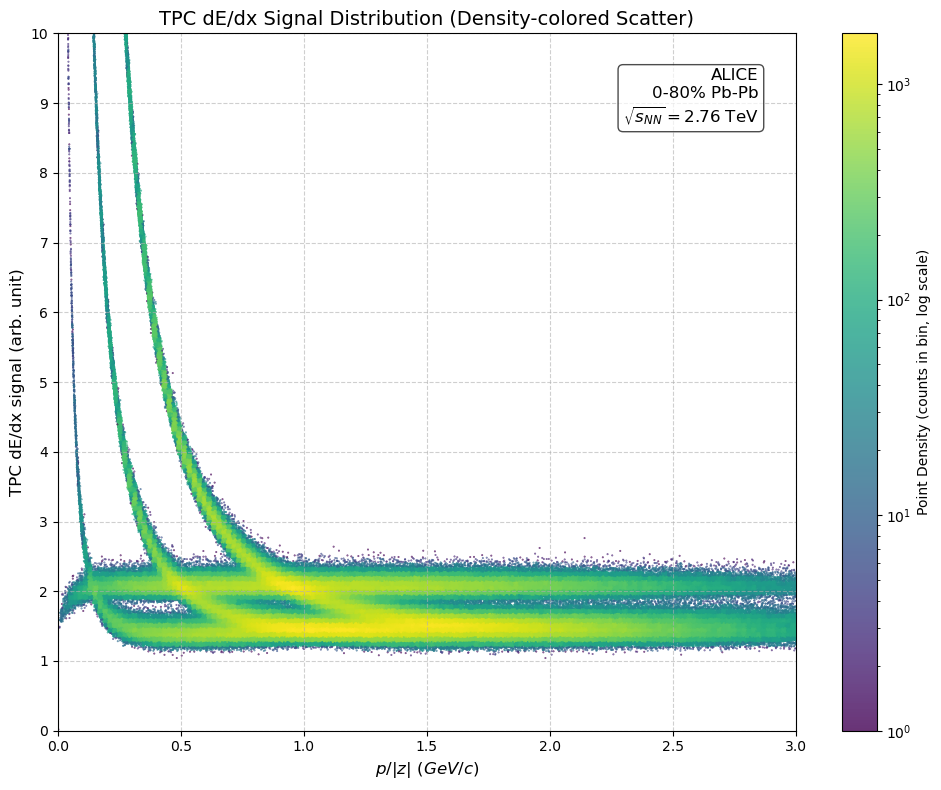

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time 
from matplotlib.colors import LogNorm # 导入对数颜色归一化

# 文件路径
file_path = 'dedx_sample_28_1000000.txt'

# 用于存储结果的列表
x_values_collected = []  # p/|z| values
y_values_collected = []  # truncated mean of dE/dx

particle_count = 0
start_time = time.time()

# 提前定义需要截取的dE/dx数据点数量
NUM_DE_DX_VALUES = 50
TRUNCATE_COUNT = 30 # 保留30个最低值

print("Starting data processing for ALL particles...")

with open(file_path, 'r') as file:
    while True:
        header_line = file.readline()
        if not header_line: 
            break  # 文件结束

        try:
            header = header_line.strip().split(',')
            p = float(header[1])
            z = 1
            x_val = p / abs(z) if z != 0 else 0  # 防止除以零
            
            dedx_values_raw = [float(file.readline().strip()) for _ in range(NUM_DE_DX_VALUES)]
            
            dedx_array = np.array(dedx_values_raw)
            
            if TRUNCATE_COUNT > NUM_DE_DX_VALUES:
                truncated_mean = np.mean(dedx_array)
            else:
                dedx_smallest_values = np.partition(dedx_array, TRUNCATE_COUNT)[:TRUNCATE_COUNT]
                truncated_mean = np.mean(dedx_smallest_values)
            
            x_values_collected.append(x_val)
            y_values_collected.append(truncated_mean)
                
            particle_count += 1
            if particle_count % 100000 == 0:
                print(f"Processed {particle_count} particles... Time elapsed: {time.time() - start_time:.2f}s")
                
        except Exception as e:
            print(f"Error processing particle {particle_count}: {e}. Last header line: '{header_line.strip()}'")
            break

end_time = time.time()
print(f"Total particles processed: {particle_count}")
print(f"Time taken for processing: {end_time - start_time:.2f} seconds")
print(f"Total points for plotting: {len(x_values_collected)}")

# 将收集到的列表转换为NumPy数组
x_values = np.array(x_values_collected)
y_values = np.array(y_values_collected)

# --- 数据分布信息  ---
print("\n--- Data Distribution Info (of ALL points) ---")
print(f"X-axis (p/|z|) range: Min={np.min(x_values):.3f}, Max={np.max(x_values):.3f}")
print(f"X-axis percentiles (1st, 5th, 95th, 99th): {np.quantile(x_values, [0.01, 0.05, 0.95, 0.99]).round(3)}")
print(f"Y-axis (dE/dx) range: Min={np.min(y_values):.3f}, Max={np.max(y_values):.3f}")
print(f"Y-axis percentiles (1st, 5th, 95th, 99th): {np.quantile(y_values, [0.01, 0.05, 0.95, 0.99]).round(3)}")
print("--------------------------------------------------\n")


# --- 为散点图计算密度并映射到颜色 ---
# 定义用于密度计算的2D直方图的bin
#(x轴0-3，y轴0-10)
# bin的数量可以适当多一些，以提供更精细的密度图
x_bins_density = np.linspace(0, 3, 150) # x轴范围0-3，分成150个bin
y_bins_density = np.linspace(0, 10, 150) # y轴范围0-10，分成150个bin

# 计算2D直方图的计数
# 记住histogram2d返回的counts是(nx, ny)的形状
counts, xedges, yedges = np.histogram2d(x_values, y_values, bins=[x_bins_density, y_bins_density])

# 为每个散点找到其所在的bin，并获取该bin的密度值
# np.digitize 返回的是1-based的索引，并且对于落在上边界上的点会分配到下一个bin的索引
# 所以需要减1，并且对索引进行裁剪，使其在counts数组的有效范围内
x_indices = np.digitize(x_values, xedges) - 1
y_indices = np.digitize(y_values, yedges) - 1

# 裁剪索引，确保它们不会超出counts数组的边界
# 注意：np.clip(indices, 0, max_index) 确保索引在 [0, max_index] 范围内
# xedges/yedges 长度比 bins 多1，counts 数组的形状是 (len(x_bins)-1, len(y_bins)-1)
x_indices = np.clip(x_indices, 0, counts.shape[0] - 1)
y_indices = np.clip(y_indices, 0, counts.shape[1] - 1)

# 获取每个点的密度值
point_densities = counts[x_indices, y_indices]

# --- 创建散点图 ---
plt.figure(figsize=(10, 8))

# 绘制散点图，使用point_densities作为颜色值，并应用LogNorm
# c=point_densities: 根据密度值着色
# cmap='viridis': 选择一种颜色映射，'viridis' 是一种感知均匀的颜色图，适合显示连续数据
# s=0.2: 点的大小调整为更小，以便在高密度区域显示更清晰，避免过度填充
# alpha=0.8: 透明度，适当的透明度可以帮助在点叠加时仍然显示颜色差异
# rasterized=True: 必需！当点非常多时，将散点图部分渲染为像素图，显著优化文件大小和渲染速度
# norm=LogNorm(vmin=1): 应用对数颜色映射。vmin=1 表示颜色条的最低值对应密度1，0密度点不会被着色（或着色为背景色），更好地显示密度的变化范围。
scatter = plt.scatter(x_values, y_values, c=point_densities, cmap='viridis', 
                      s=0.2, alpha=0.8, rasterized=True, norm=LogNorm(vmin=1)) 

# 添加颜色条，指示密度
cbar = plt.colorbar(scatter)
cbar.set_label('Point Density (counts in bin, log scale)') # 颜色条的标签

# 设置坐标轴范围和标签
# 精确聚焦 x轴0-3，y轴0-10
plt.xlim(0, 3) 
plt.ylim(0, 10) 

plt.xlabel(r'$p/|z|\ (GeV/c)$', fontsize=12)
plt.ylabel('TPC dE/dx signal (arb. unit)', fontsize=12)
plt.title('TPC dE/dx Signal Distribution (Density-colored Scatter)', fontsize=14)

# 添加ALICE实验信息
plt.text(0.95, 0.95, 'ALICE\n0-80% Pb-Pb\n$\sqrt{s_{NN}} = 2.76$ TeV',
         transform=plt.gca().transAxes, fontsize=12,
         ha='right', va='top', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# 设置Y轴刻度，根据新的ylim调整，更细致地显示0-10
plt.yticks(np.arange(0, 10.1, 1)) # 步长为1

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('dedx_distribution_plot_full_data_density_scatter.png', dpi=300) # 保存为新的文件名
plt.show()

